In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona

import shapely
from shapely.validation import make_valid
from shapely.ops import unary_union,cascaded_union 
from shapely.geometry import Polygon, MultiPolygon, shape, Point


In [2]:
from general_functions import *

def convert_to_polygon(line):
    if line.is_ring:  # Checks if the LineString is closed
        return Polygon(line)
    else:
        return line  # Returns the line string as is if it's not closed


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
#define relative paths
waterschap = 'HHSK'
path_HHSK = '..\..\Data_preprocessed\Waterschappen\HHSK\HyDamo_metWasverzachter_20230905.gpkg'
output_gpkg_path = "../../Data_postprocessed/Waterschappen/HHSK"


In [5]:
HHSK = read_gpkg_layers(gpkg_path = path_HHSK, 
                                  variables = ['stuw', 
                                               'gemaal', 
                                               'afsluitmiddel',
                                               # 'duikersifonhevel',
                                               # 'hydroobject',
                                               # 'peilgebiedvigerend',
                                               # 'peilafwijkinggebied',
                                               # 'peilbesluitgebied',
                                               'streefpeil'],
                                 engine = 'pyogrio') 
                                     

In [6]:
# HHSK_nalevering = read_gpkg_layers(gpkg_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\LHM_hhsk_nalevering.gpkg",
#                                    variables = ['Persleiding'])

In [7]:
HHSK_2nalevering = read_gpkg_layers(gpkg_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\hhsklevering_07032024.gpkg",
                                   variables = ['PeilgebiedPraktijk',
                                                'VigerendPeilgebiedZPP'])

In [8]:
HHSK_3nalevering = read_gpkg_layers(gpkg_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\poldergebieden_en_duikersifonhevels_persleidingen\LHM_06052024_hhsk.gpkg",
                                   variables = ['hydroobject',
                                                'duikersifonhevel',
                                                # 'persleiding', #edit: after a phonecall, it became clear that the persleidingen should NOT be used, only the duikersifonhevel and the hydroobjecten
                                               ])

In [9]:
HHSK_3nalevering['hydroobject'].CATEGORIEOPPWATERLICHAAM.unique()

array([98.,  1., nan])

In [10]:
#there was no categorie oppervlakte water lichaam assigned to the third additional datalevering of the duikersifonhevels within the hydroobjecten. Fill all Nones with 1, so that the 
HHSK_3nalevering['hydroobject'].CATEGORIEOPPWATERLICHAAM = HHSK_3nalevering['hydroobject'].CATEGORIEOPPWATERLICHAAM.fillna(value=1)
HHSK_3nalevering['duikersifonhevel'].STATUSOBJECT = HHSK_3nalevering['duikersifonhevel'].STATUSOBJECT.fillna(value=3)

## Only select status_object == 3

In [11]:
HHSK['stuw'] = HHSK['stuw'].loc[(HHSK['stuw']['statusobject'] == '3') | (HHSK['stuw']['statusobject'] == 3)]
HHSK['gemaal'] = HHSK['gemaal'].loc[(HHSK['gemaal']['statusobject'] == '3') | (HHSK['gemaal']['statusobject'] == 3)]
HHSK['afsluitmiddel'] = HHSK['afsluitmiddel'].loc[(HHSK['afsluitmiddel']['statusobject'] == '3') | (HHSK['afsluitmiddel']['statusobject'] == 3)]

# HHSK['peilgebiedvigerend'] = HHSK['peilgebiedvigerend'].loc[(HHSK['peilgebiedvigerend']['statusobject'] == '3') | (HHSK['peilgebiedvigerend']['statusobject'] == 3)]
# HHSK['peilafwijkinggebied'] = HHSK['peilafwijkinggebied'].loc[(HHSK['peilafwijkinggebied']['statusobject'] == '3') | (HHSK['peilafwijkinggebied']['statusobject'] == 3)]

# HHSK_3nalevering['persleiding'] = HHSK_3nalevering['persleiding'].loc[(HHSK_3nalevering['persleiding']['STATUSOBJECT'] == '3') | (HHSK_3nalevering['persleiding']['STATUSOBJECT'] == 3)]
HHSK_3nalevering['hydroobject'] = HHSK_3nalevering['hydroobject'].loc[(HHSK_3nalevering['hydroobject']['STATUSOBJECT'] == '3') | (HHSK_3nalevering['hydroobject']['STATUSOBJECT'] == 3)]
HHSK_3nalevering['duikersifonhevel'] = HHSK_3nalevering['duikersifonhevel'].loc[(HHSK_3nalevering['duikersifonhevel']['STATUSOBJECT'] == '3') | (HHSK_3nalevering['duikersifonhevel']['STATUSOBJECT'] == 3)]

In [12]:
dsf = HHSK_3nalevering['hydroobject'].loc[HHSK_3nalevering['hydroobject']['CODE'].str.contains('Duiker|Sifon|Hevel|Gemaal|Inlaat', na=False)]
HHSK['duikersifonhevel'] = pd.concat([HHSK_3nalevering['duikersifonhevel'], dsf])
HHSK['duikersifonhevel'] = gpd.GeoDataFrame(HHSK['duikersifonhevel'], geometry='geometry')

In [13]:
HHSK_3nalevering['hydroobject']['CATEGORIEOPPWATERLICHAAM'] = HHSK_3nalevering['hydroobject']['CATEGORIEOPPWATERLICHAAM'].astype(float)
HHSK_3nalevering['hydroobject_original'] = HHSK_3nalevering['hydroobject'].copy()
HHSK['hydroobject'] = HHSK_3nalevering['hydroobject'].loc[HHSK_3nalevering['hydroobject']['CATEGORIEOPPWATERLICHAAM'] == 1] #only select primaire waterlichamen

# HHSK

### Add the gemalen columns

In [14]:
#determine aanvoer en afvoer gemalen
HHSK['gemaal']['func_aanvoer'], HHSK['gemaal']['func_afvoer'], HHSK['gemaal']['func_circulatie']  = False, False, False #default is False
HHSK['gemaal']['functiegemaal'] = HHSK['gemaal']['functiegemaal'].astype(str) 

HHSK['gemaal'].loc[HHSK['gemaal'].functiegemaal.str.contains('2|4|5|6|7|99'), 'func_afvoer'] = True
HHSK['gemaal'].loc[HHSK['gemaal'].functiegemaal.str.contains('1|3|5'), 'func_aanvoer'] = True
HHSK['gemaal'].loc[HHSK['gemaal'].functiegemaal.str.contains('8'), 'func_circulatie'] = True
HHSK['gemaal'].loc[(HHSK['gemaal'].func_afvoer == False) &
                       (HHSK['gemaal'].func_aanvoer == False) &
                       (HHSK['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [15]:
HHSK['hydroobject']['code'] = HHSK['hydroobject'].CODE
HHSK['hydroobject']['nen3610id'] = 'dummy_nen3610id_' + HHSK['hydroobject'].index.astype(str)
HHSK['hydroobject']['globalid'] = HHSK['hydroobject'].GLOBALID

HHSK['duikersifonhevel']['code'] = HHSK['duikersifonhevel'].CODE
HHSK['duikersifonhevel']['nen3610id'] = 'dummy_nen3610id_' + HHSK['duikersifonhevel'].index.astype(str)
HHSK['duikersifonhevel']['globalid'] = HHSK['duikersifonhevel'].GLOBALID

C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [16]:
HHSK['stuw'] = HHSK['stuw'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['gemaal'] = HHSK['gemaal'][['code', 'nen3610id', 'globalid', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
HHSK['hydroobject'] = HHSK['hydroobject'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['duikersifonhevel'] = HHSK['duikersifonhevel'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['afsluitmiddel'] = HHSK['afsluitmiddel'][['code', 'nen3610id', 'globalid', 'geometry']]

# HHSK['peilgebiedvigerend'] = HHSK['peilgebiedvigerend'][['code', 'nen3610id', 'globalid', 'geometry']]
# HHSK['peilafwijkinggebied'] = HHSK['peilafwijkinggebied'][['code', 'nen3610id', 'globalid', 'geometry']]

# HHSK['streefpeil'] = HHSK['streefpeil'][['code', 'nen3610id', 'globalid']]

### Add the nageleverde persleidingen to the duikersifonhevels

In [17]:
# HHSK_3nalevering['persleiding'] = HHSK_3nalevering['persleiding'][['CODE', 'GLOBALID', 'geometry']]
# HHSK_3nalevering['persleiding']['nen3610id'] = 'dummy_nen3610id_persleiding_' + HHSK_3nalevering['persleiding'].index.astype(str)
# HHSK_3nalevering['persleiding'] = HHSK_3nalevering['persleiding'].rename(columns = {'CODE': 'code',
#                                                                         'GLOBALID': 'globalid'})


In [18]:
# HHSK['duikersifonhevel'] = gpd.GeoDataFrame(pd.concat([HHSK['duikersifonhevel'], HHSK_3nalevering['persleiding']])).reset_index(drop=True)

#HHSK has apparently non unique values for the global ids in duikersifonhevel
HHSK['duikersifonhevel'] = HHSK['duikersifonhevel'].reset_index(drop=True)
HHSK['duikersifonhevel']['globalid'] = 'dummy_globalid_duikersifonhevel_' + HHSK['duikersifonhevel'].index.astype(str)

#remove empty point geomtries from the gemalen
HHSK['gemaal'] = HHSK['gemaal'][~HHSK['gemaal'].is_empty].reset_index(drop=True)

### Add the nageleverde peilgebieden to the original data

In [19]:
HHSK_2nalevering['PeilgebiedPraktijk'].loc[HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'] == 0, 'ONDERPEIL'] = np.nan
HHSK_2nalevering['PeilgebiedPraktijk'].loc[HHSK_2nalevering['PeilgebiedPraktijk']['VASTPEIL'] == 0, 'VASTPEIL'] = np.nan
HHSK_2nalevering['PeilgebiedPraktijk'].loc[HHSK_2nalevering['PeilgebiedPraktijk']['BOVENPEIL'] == 0, 'BOVENPEIL'] = np.nan
HHSK_2nalevering['PeilgebiedPraktijk'].loc[HHSK_2nalevering['PeilgebiedPraktijk']['SCHOUWPEIL'] == 0, 'SCHOUWPEIL'] = np.nan

HHSK_2nalevering['VigerendPeilgebiedZPP'].loc[HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'] == 0, 'ONDERPEIL'] = np.nan
HHSK_2nalevering['VigerendPeilgebiedZPP'].loc[HHSK_2nalevering['VigerendPeilgebiedZPP']['VASTPEIL'] == 0, 'VASTPEIL'] = np.nan
HHSK_2nalevering['VigerendPeilgebiedZPP'].loc[HHSK_2nalevering['VigerendPeilgebiedZPP']['BOVENPEIL'] == 0, 'BOVENPEIL'] = np.nan
HHSK_2nalevering['VigerendPeilgebiedZPP'].loc[HHSK_2nalevering['VigerendPeilgebiedZPP']['SCHOUWPEIL'] == 0, 'SCHOUWPEIL'] = np.nan

In [20]:
#edit the peilgebiedpraktijk
HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'].fillna(HHSK_2nalevering['PeilgebiedPraktijk']['VASTPEIL'], inplace= True)
HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'].fillna(HHSK_2nalevering['PeilgebiedPraktijk']['BOVENPEIL'], inplace= True)
HHSK_2nalevering['PeilgebiedPraktijk']['ONDERPEIL'].fillna(HHSK_2nalevering['PeilgebiedPraktijk']['SCHOUWPEIL'], inplace= True)

HHSK['peilgebiedpraktijk'] = HHSK_2nalevering['PeilgebiedPraktijk'][['CODE', 'ONDERPEIL', 'BRONGID', 'geometry']]
HHSK['peilgebiedpraktijk'] = HHSK_2nalevering['PeilgebiedPraktijk'].rename(columns = {'CODE': 'code',
                                                                                      'ONDERPEIL': 'waterhoogte',
                                                                                      'BRONGID': 'globalid'})

In [21]:
#edit the peilgebiedvigerend
HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'].fillna(HHSK_2nalevering['VigerendPeilgebiedZPP']['VASTPEIL'], inplace= True)
HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'].fillna(HHSK_2nalevering['VigerendPeilgebiedZPP']['BOVENPEIL'], inplace= True)
HHSK_2nalevering['VigerendPeilgebiedZPP']['ONDERPEIL'].fillna(HHSK_2nalevering['VigerendPeilgebiedZPP']['SCHOUWPEIL'], inplace= True)

HHSK['peilgebiedvigerend'] = HHSK_2nalevering['VigerendPeilgebiedZPP'][['CODE', 'ONDERPEIL', 'BRONGID', 'geometry']]
HHSK['peilgebiedvigerend'] = HHSK_2nalevering['VigerendPeilgebiedZPP'].rename(columns = {'CODE': 'code',
                                                                                         'ONDERPEIL': 'waterhoogte',
                                                                                         'BRONGID': 'globalid'})

In [22]:
#select the peilgebiedpraktijk which have a primaire hydroobject

#pgp_pw : PeilGebiedPraktijk Primaire Watergang
pgp_pw = gpd.sjoin(left_df = HHSK_2nalevering['PeilgebiedPraktijk'], 
                   right_df = HHSK['hydroobject'],
                   how="inner", 
                   predicate='contains',
                   lsuffix = 'pgp',
                   rsuffix = 'hydroobject').drop_duplicates(subset='CODE') 


# Insert the manually created GPKG's

In [23]:
# VASTPEIL	BOVENPEIL	ONDERPEIL	SCHOUWPEIL

In [24]:
first = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\korte_analyse_nalevering_HHSK.gpkg", layer = 'peilgebied_praktijk_met_primaire_watergangen')
second = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\korte_analyse_nalevering_HHSK.gpkg", layer = 'peilgebied_vigerend_boven_1ha')
areas = pd.concat([first, second])
areas = gpd.GeoDataFrame(areas, geometry = 'geometry')
areas = areas.loc[areas.area > 100] #filter out the smallest areas 
areas.reset_index(drop=True, inplace=True)

areas.loc[areas['ONDERPEIL'] == 0, 'ONDERPEIL'] = np.nan
areas.loc[areas['VASTPEIL'] == 0, 'VASTPEIL'] = np.nan
areas.loc[areas['BOVENPEIL'] == 0, 'BOVENPEIL'] = np.nan
areas.loc[areas['SCHOUWPEIL'] == 0, 'SCHOUWPEIL'] = np.nan


areas['ONDERPEIL'].fillna(areas['VASTPEIL'], inplace= True)
areas['ONDERPEIL'].fillna(areas['BOVENPEIL'], inplace= True)
areas['ONDERPEIL'].fillna(areas['SCHOUWPEIL'], inplace= True)
areas['waterhoogte'] = areas['ONDERPEIL']
HHSK['peilgebied']  = areas
HHSK['peilgebied'] = HHSK['peilgebied'].loc[HHSK['peilgebied']['CODE'] !='GPG-1206'] #Not a regular polygon
HHSK['peilgebied'] = HHSK['peilgebied'].loc[:,['CODE', 'waterhoogte', 'geometry']]
HHSK['peilgebied'] = HHSK['peilgebied'].rename(columns = {'CODE': 'code'})#,
#                                                           'ONDERPEIL': 'waterhoogte',
#                                                           'BRONGID': 'globalid'})


# Remove and add the (splitted) boezem, partly manual
HHSK['peilgebied'] = HHSK['peilgebied'].loc[HHSK['peilgebied'].code != 'PPG-237']
HHSK['peilgebied'] = HHSK['peilgebied'].loc[HHSK['peilgebied'].code != 'PPG-1053']
HHSK['peilgebied'] = HHSK['peilgebied'].loc[HHSK['peilgebied'].code != 'PPG-49']


In [25]:

splitted_boezem = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\boezem\boezem_split.shp")
splitted_boezem['code'] = splitted_boezem['code'].str.split('_').str[0]
splitted_boezem = splitted_boezem[['code', 'nen3610id', 'globalid', 'geometry']]
splitted_boezem = pd.merge(left=splitted_boezem,
                           right = HHSK['peilgebied'][['code', 'waterhoogte']],
                           left_on = 'code',
                           right_on = 'code',
                           how = 'left')
splitted_boezem['code'] = splitted_boezem['code'] + '_boezem_' + splitted_boezem['code'].index.astype(str)

HHSK['peilgebied'] = pd.concat([HHSK['peilgebied'], splitted_boezem]).reset_index(drop=True)
#globalid is not unique, change
# HHSK['peilgebied']['code'] = 'dummy_code_peilgebied_' + HHSK['peilgebied'].index.astype(str)
HHSK['peilgebied']['nen3610id'] = 'dummy_nen3610id_peilgebied_' + HHSK['peilgebied'].index.astype(str)
HHSK['peilgebied']['globalid'] = 'dummy_globalid_peilgebied_' + HHSK['peilgebied'].index.astype(str)

HHSK['peilgebied'] = gpd.GeoDataFrame(HHSK['peilgebied'], geometry='geometry')

In [26]:
# test = gpd.GeoDataFrame(columns=['test', 'geometry'])
# test['test'] = np.nan
# test[0, 'geometry'] = dissolved_polygon
# test.rename(columns={'(0, geometry)': 'geometry'}, inplace=True)
# test['geometry'] = test.iloc[:, 2]
# test = test[['geometry']]
# test.set_crs('EPSG:28992')
# test.to_file('snelle_test.gpkg', driver='GPKG') 

In [27]:
peilbesluit = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\poldergebieden_en_duikersifonhevels_persleidingen\peilbesluit_hhsk.gpkg")


In [28]:
joined_gdf = gpd.sjoin(HHSK['peilgebied'], peilbesluit, how='left', op='intersects')
# joined_gdf.globalid = joined_gdf.globalid.astype(str) + '_' + joined_gdf.globalid.index.astype(str)

C:\Users\Bruijns\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [29]:
HHSK['peilgebied']['id'] = HHSK['peilgebied'].index
HHSK['peilgebied']['area'] = HHSK['peilgebied'].area

# Step 1: Calculate intersections with overlay, ensure to keep the identifier
intersections = gpd.overlay(HHSK['peilgebied'], peilbesluit, how='intersection', keep_geom_type=False)
intersections['intersection_area'] = intersections.area

# Step 2: Merge back with HHSK['peilgebied'] to get the original areas using the identifier
intersections = intersections.merge(HHSK['peilgebied'][['id', 'area']], left_on='id', right_on='id', how='left', suffixes=('', '_original'))

# Step 3: Calculate the percentage of the intersection area relative to the original area
intersections['overlap_percentage'] = (intersections['intersection_area'] / intersections['area_original']) * 100

# Step 4: Filter out intersections with less than 10% overlap
significant_intersections = intersections[intersections['overlap_percentage'] >= 10]

# Step 5: Join significant intersections back to the original HHSK['peilgebied']
joined_gdf = HHSK['peilgebied'].merge(significant_intersections[['id', 'NAAM']], on='id', how='left')


In [30]:
joined_gdf = joined_gdf.reset_index(drop=True)
joined_gdf.sort_values(by=['globalid', 'area'], inplace=True)
joined_gdf.drop_duplicates(subset='globalid', keep = 'first', inplace = True)
joined_gdf = joined_gdf.reset_index(drop=True)
HHSK['peilgebied'] = joined_gdf

In [31]:
# new_gdf = gpd.GeoDataFrame(columns=Zuiderzeeland['peilgebied'].columns())
HHSK['peilgebied'] = HHSK['peilgebied'].explode(ignore_index=True).reset_index(drop=True) #explode to prevent multipolygons
HHSK['peilgebied']['area'] = HHSK['peilgebied'].area

#remove all areas which are smaller than 25 hectares (25*100*100)
HHSK['peilgebied'] = HHSK['peilgebied'].loc[HHSK['peilgebied'].area > 25*100*100]

In [32]:
HHSK['peilgebied'] = HHSK['peilgebied'].explode(ignore_index=True)
HHSK['peilgebied'] = HHSK['peilgebied'][HHSK['peilgebied'].geometry.type.isin(['Polygon', 'MultiPolygon'])] #also only select polygons


HHSK['peilgebied']['area'] = HHSK['peilgebied'].area
dissolved = HHSK['peilgebied'].dissolve()
exterior = gpd.GeoDataFrame(geometry=dissolved['geometry'].boundary).to_crs(crs='EPSG:28992')
HHSK['peilgebied'] = HHSK['peilgebied'].to_crs(crs='EPSG:28992')
exterior = exterior.explode().reset_index(drop=True)
exterior['geometry'] = exterior['geometry'].apply(convert_to_polygon)
exterior['area'] = exterior.area
exterior = exterior.sort_values(by='area', ascending=False).reset_index(drop=True)
exterior = exterior.iloc[2::] #-2 as all rows should be taken into consideration, except the last two as HHSK consists of "two islands"
exterior = exterior.reset_index(drop=True)

#determine the polder at which each exterior is laying
exterior['id'] = exterior.index
exterior['area'] = exterior.area

# intersections = gpd.overlay(exterior, peilbesluit, how='intersection', keep_geom_type=False)
# intersections['intersection_area'] = intersections.area
# intersections = intersections.merge(exterior[['id', 'area']], left_on='id', right_on='id', how='left', suffixes=('', '_original'))
# intersections['overlap_percentage'] = (intersections['intersection_area'] / intersections['area_original']) * 100
# significant_intersections = intersections[intersections['overlap_percentage'] >= 10]
# joined_gdf2 = exterior.merge(significant_intersections[['id', 'NAAM']], on='id', how='left')

intersections = gpd.overlay(exterior, peilbesluit, how='intersection', keep_geom_type=False)
intersections['intersection_area'] = intersections.area
intersections = intersections.merge(exterior[['id', 'area']], left_on='id', right_on='id', how='left', suffixes=('', '_original'))
# intersections['overlap_percentage'] = (intersections['intersection_area'] / intersections['area_original']) * 100
# significant_intersections = intersections[intersections['overlap_percentage'] >= 10]
joined_gdf2 = exterior.merge(intersections[['id', 'NAAM']], on='id', how='left')


joined_gdf2 = joined_gdf2.reset_index(drop=True)
joined_gdf2.sort_values(by=['id', 'area'], inplace=True)
joined_gdf2.drop_duplicates(subset='id', keep = 'first', inplace = True)
exterior = joined_gdf2.reset_index(drop=True)



for i in range(len(exterior)):
# for i in range(10):

    buffered_peilgebied = HHSK['peilgebied'].buffer(0.)

    exterior_sample = exterior.iloc[i:i+1] #just pick a single sample
    exterior_sample.geometry = exterior_sample.buffer(0.0001) #let op! hierdoor komt er alsnog een kleine overlap. Maar anders werkt de code even niet, en vanwege tijdgebrek kan dit nu niet worden opgelost. In het bepalen van de crossings wordt hier echter mee omgegaan.
    exterior_sample_NAAM = exterior_sample.NAAM
    
    intersects_mask = buffered_peilgebied.intersects(exterior_sample.iloc[0].geometry)
    intersecting_polygons = HHSK['peilgebied'][intersects_mask].sort_values(by='area', ascending=False)

    intersecting_polygons = intersecting_polygons.loc[intersecting_polygons.NAAM.values == exterior_sample_NAAM.values]

    if len(intersecting_polygons) > 0:
        intersecting_polygons = gpd.GeoDataFrame(intersecting_polygons.iloc[0:1], geometry = 'geometry')
        all_geometries = list(intersecting_polygons.geometry) + list(exterior_sample.geometry)

        # Use unary_union to dissolve all polygons in the list
        dissolved_polygon = unary_union(all_geometries)
        
        original_index = intersecting_polygons.index[0]

        # Ensure it's a single geometry object.
        HHSK['peilgebied'].loc[HHSK['peilgebied'].index == original_index, 'geometry'] = dissolved_polygon
    else:
        print('No intersection found for iteration ', i)

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_17744\3850806707.py:9: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exterior = exterior.explode().reset_index(drop=True)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


No intersection found for iteration  38
No intersection found for iteration  60
No intersection found for iteration  92
No intersection found for iteration  98
No intersection found for iteration  103
No intersection found for iteration  119
No intersection found for iteration  142
No intersection found for iteration  245
No intersection found for iteration  389
No intersection found for iteration  437


In [33]:
#door niet lekker liggende intekeningen met peilbesluiten, blijven er een aantal gaten inzitten...
#handmatig gebieden aan andere toegekend. Helaas was dit nodig om zo een betere schematisatie af te leiden

verwerkte_peilgebieden = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\poldergebieden_en_duikersifonhevels_persleidingen\Opgevulde_peilgebieden_dmv_nalevering_en_handmatige_aggregatie2.shp")
verwerkte_peilgebieden = gpd.GeoDataFrame(verwerkte_peilgebieden, geometry = 'geometry')

In [34]:
# for i in range(len(verwerkte_peilgebieden.loc[verwerkte_peilgebieden.CODE == 'PPG-1596'])):
#     # display(verwerkte_peilgebieden.iloc[i])
#     verwerkte_peilgebieden.loc[verwerkte_peilgebieden.CODE == 'PPG-1596'].iloc[i::i+1].plot()
#     # plt.show()

In [35]:
merged = pd.merge(verwerkte_peilgebieden,
                  HHSK['peilgebied'],
                  on = 'nen3610id')


In [36]:
merged['geometry'] = merged['geometry_x']
merged['globalid'] = merged['globalid_x']


merged = merged[['code', 'waterhoogte', 'nen3610id', 'globalid', 'geometry']]

In [37]:
twee_overige_gebieden = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\poldergebieden_en_duikersifonhevels_persleidingen\2_overige_gebieden.shp")
twee_overige_gebieden['code'] = 'code_2_overige_gebieden_' + twee_overige_gebieden.index.astype(str)
twee_overige_gebieden['nen3610id'] = 'nen3610id_2_overige_gebieden_' + twee_overige_gebieden.index.astype(str)
twee_overige_gebieden['globalid'] = 'globalid_2_overige_gebieden_' + twee_overige_gebieden.index.astype(str)
twee_overige_gebieden['waterhoogte'] = -5.95

twee_overige_gebieden = twee_overige_gebieden[['code', 'waterhoogte', 'nen3610id', 'globalid', 'geometry']]

merged = gpd.GeoDataFrame(pd.concat([merged, twee_overige_gebieden]), geometry = 'geometry')
HHSK['peilgebied'] = merged.reset_index(drop=True)

In [38]:
# HHSK['streefpeil']['last_id'] = HHSK['streefpeil']['globalid'].str.split('area_').str[1]
# HHSK['verwerkte_peilgebieden']['last_id'] = HHSK['streefpeil']['globalid'].str.split('area_').str[1]

In [39]:
# verwerkte_peilgebieden.loc[verwerkte_peilgebieden.VASTPEIL.isna()].plot()

In [40]:
# pgv_diff = gpd.sjoin(left_df =  HHSK['peilgebiedvigerend'],
#                      right_df = pgp_pw,
#                      how = "left",
#                      predicate = 'intersects')

In [41]:
# pgv_diff.drop_duplicates()#.plot()

In [42]:
# streefpeilen_PG_v = pd.merge(left = HHSK['peilgebiedvigerend'],
#                              right = HHSK['streefpeil'],
#                              left_on = 'globalid',
#                              right_on = 'peilgebiedvigerendid',
#                              suffixes = ('', '_streefpeil'))[['code', 'nen3610id', 'globalid', 'waterhoogte', 'geometry']]

# streefpeilen_PG_a = pd.merge(left = HHSK['peilafwijkinggebied'],
#                              right = HHSK['streefpeil'],
#                              left_on = 'globalid',
#                              right_on = 'peilafwijkinggebiedid',
#                              suffixes = ('', '_streefpeil'))[['code', 'nen3610id', 'globalid', 'waterhoogte', 'geometry']]

# fig, ax = plt.subplots()
# streefpeilen_PG_v.plot(ax = ax, color='cornflowerblue')
# streefpeilen_PG_a.plot(ax = ax, color='blue')

In [43]:
# streefpeilen_PG_v.to_file('vigerend.shp')
# streefpeilen_PG_a.to_file('afwijking.shp')

In [44]:
# peilgebied = burn_in_peilgebieden(base_layer = streefpeilen_PG_v, 
#                                   overlay_layer = streefpeilen_PG_a,
#                                   plot = True)

In [45]:
# HHSK['peilgebied'].code = HHSK['peilgebied'].dropna(subset='code')

In [46]:
HHSK['peilgebied'].loc[HHSK['peilgebied'].code.str.contains('PPG-49_boezem'), 'waterhoogte'] = -2.15
HHSK['peilgebied'].loc[HHSK['peilgebied'].code.str.contains('PPG-237_boezem'), 'waterhoogte'] = -0.9
HHSK['peilgebied'].loc[HHSK['peilgebied'].code.str.contains('PPG-1053_boezem'), 'waterhoogte'] = -2.1


In [47]:
1

1

In [48]:
# HHSK['peilgebied'] = gpd.GeoDataFrame(peilgebied[['code', 'nen3610id', 'globalid', 'geometry']])

### Delete irrelevant data

In [49]:
#retrieve the original hydroobjecten back, where also the secundairy and tertiairy hydroobjects are present
# HHSK['hydroobject'] = HHSK['hydroobject_original']

#delete irrelvant data
variables = ['peilgebiedpraktijk', 'peilgebiedvigerend', 'peilafwijkinggebied', 'hydroobject_original']

for variable in variables:
    if str(variable) in HHSK:
        del HHSK[variable]

In [50]:
HHSK['hydroobject'] = HHSK['hydroobject'][['code', 'globalid', 'nen3610id', 'geometry']]

#add duikersifonhevels to the hydroobjecten    
HHSK['hydroobject'] = pd.concat([HHSK['hydroobject'], HHSK['duikersifonhevel']])
HHSK['hydroobject'] = HHSK['hydroobject'].drop_duplicates(subset='globalid') #in case it is run multiple times
HHSK['hydroobject'] = gpd.GeoDataFrame(HHSK['hydroobject']).set_crs('epsg:28992')


In [51]:
aggregation_area = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\20240701_losseshapes\basin_area_hhsk.shp")
HHSK['aggregation_area'] = aggregation_area
HHSK['aggregation_area']['globalid'] = 'dummy_globalid_' + HHSK['aggregation_area'].index.astype(str)
HHSK['aggregation_area']['nen3610id'] = 'dummy_nen3610id_' + HHSK['aggregation_area'].index.astype(str)
HHSK['aggregation_area']['code'] = 'dummy_code_' + HHSK['aggregation_area'].index.astype(str)

### The streefpeilen are not correct anymore. Load in an old data delivery, and retrieve the streefpeilen by using a spatial join

In [52]:
#read file with old streefpeilen
old_SP = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\HHSK\hhsklevering_07032024.gpkg"
old_SP = gpd.read_file(old_SP)

#replace 0 with nan
old_SP.loc[old_SP['ONDERPEIL'] == 0, 'ONDERPEIL'] = np.nan
old_SP.loc[old_SP['VASTPEIL'] == 0, 'VASTPEIL'] = np.nan
old_SP.loc[old_SP['BOVENPEIL'] == 0, 'BOVENPEIL'] = np.nan
old_SP.loc[old_SP['SCHOUWPEIL'] == 0, 'SCHOUWPEIL'] = np.nan

#fill nan with actual values
old_SP['ONDERPEIL'].fillna(old_SP['VASTPEIL'], inplace= True)
old_SP['ONDERPEIL'].fillna(old_SP['BOVENPEIL'], inplace= True)
old_SP['ONDERPEIL'].fillna(old_SP['SCHOUWPEIL'], inplace= True)
old_SP['waterhoogte'] = old_SP['ONDERPEIL']

#repeat for the NAAM
old_SP['NAAM'].replace(to_replace = ' ', value = '', inplace=True)
old_SP['NAAM'].replace(to_replace = '', value = np.nan, inplace=True)
old_SP['NAAM'].fillna(old_SP['PEILBESLUI'], inplace= True)

#rename
old_SP = old_SP[['CODE', 'NAAM', 'PEILBESLUI', 'waterhoogte', 'geometry']]
old_SP.rename(columns = {'CODE': 'code',
                        'NAAM': 'globalid',
                        'PEILBESLUI' : 'nen3610id'}, inplace=True)

In [53]:
HHSK['aggregation_area']['repr_point'] = HHSK['aggregation_area']['geometry'].representative_point()
joined_gdf = gpd.sjoin(aggregation_area.set_geometry('repr_point'), old_SP, how='left', predicate='intersects')
joined_gdf.rename(columns={'code_right':'code',
                           'globalid_right': 'globalid',
                           'nen3610id_right': 'nen3610id'}, inplace=True)
joined_gdf = joined_gdf[['code', 'globalid', 'nen3610id', 'waterhoogte', 'geometry']]

In [54]:
#make unique rows
joined_gdf['code'] = joined_gdf['code'] + '_' + joined_gdf.index.astype(str)
joined_gdf['globalid'] = joined_gdf['globalid'] + '_' + joined_gdf.index.astype(str)
joined_gdf['nen3610id'] = joined_gdf['nen3610id'] + '_' + joined_gdf.index.astype(str)

#change all comma's to underscores
joined_gdf.code = joined_gdf.code.str.replace(pat = ',', repl = '_')
joined_gdf.nen3610id = joined_gdf.nen3610id.str.replace(pat = ',', repl = '_')
joined_gdf.globalid = joined_gdf.globalid.str.replace(pat = ',', repl = '_')

#make floats of the waterhoogte, just to be sure
joined_gdf.waterhoogte = joined_gdf.waterhoogte.astype(float)

In [55]:
HHSK['aggregation_area'] = gpd.GeoDataFrame(joined_gdf, geometry = 'geometry')
HHSK['peilgebied'] = HHSK['aggregation_area'][['code', 'nen3610id', 'globalid', 'geometry']]
HHSK['streefpeil'] = HHSK['aggregation_area'][['waterhoogte', 'globalid', 'geometry']]
HHSK['streefpeil']['geometry'] = np.nan

HHSK['aggregation_area'] = HHSK['aggregation_area'][['code', 'nen3610id', 'globalid', 'geometry']]

C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:
# # HHSK['aggregation_area'] = HHSK['peilgebied']
# HHSK['aggregation_area'] = aggregation_area
# HHSK['aggregation_area']['globalid'] = 'dummy_globalid_agg_area_' + HHSK['aggregation_area'].index.astype(str)
# HHSK['aggregation_area']['code'] = 'dummy_code_' + HHSK['aggregation_area'].index.astype(str)


In [57]:
# # stop
# streefpeil = gpd.GeoDataFrame()
# streefpeil['waterhoogte'] = HHSK['peilgebied']['waterhoogte']
# streefpeil['globalid'] = HHSK['peilgebied']['globalid']
# streefpeil['geometry'] = np.nan
# HHSK['streefpeil'] = streefpeil #gpd.GeoDataFrame(HHSK['peilgebied'])
# HHSK['streefpeil'].waterhoogte = HHSK['streefpeil'].waterhoogte.round(2)
# HHSK['peilgebied'] = HHSK['peilgebied'][['geometry', 'code', 'nen3610id', 'globalid']]

In [58]:
# HHSK['streefpeil'].waterhoogte#.plot()

<AxesSubplot:>

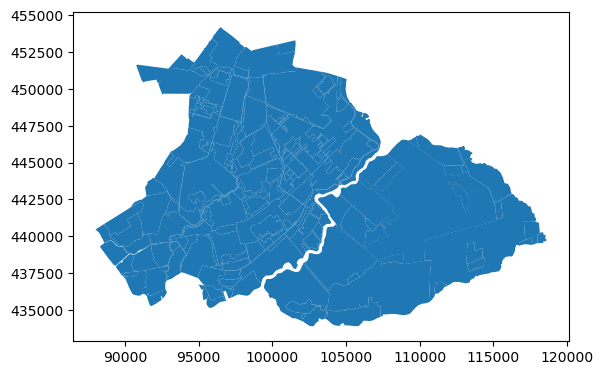

In [59]:
HHSK['peilgebied'].plot()

### Check for the correct keys and columns

In [60]:
show_layers_and_columns(waterschap = HHSK)

stuw
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

gemaal
['code' 'nen3610id' 'globalid' 'func_afvoer' 'func_aanvoer'
 'func_circulatie' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

afsluitmiddel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

peilgebied
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

aggregation_area
['code' 'nen3610id' 'globalid' 'geometry']
type =  

### Store data

In [61]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = HHSK, 
           output_gpkg_path = output_gpkg_path + '/HHSK')


In [62]:
print(len(HHSK['duikersifonhevel'].globalid.unique()))
print(len(HHSK['duikersifonhevel'].globalid))

12509
12509
